In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
np.random.seed(42)


Breast cancer dataset is used as it is a binary classification dataset with clean numerical features, making regularization effects on weights easy to analyze.
It allows us to study model complexity, weight shrinkage, and sparsity without confounding data issues.

In [ ]:
data = load_breast_cancer()

X = data.data        # Features
y = data.target      # Labels

print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Class distribution:", np.bincount(y))

df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print(df.head())


Number of samples: 569
Number of features: 30
Class distribution: [212 357]
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


The data should be scaled because regularization penalizes weight magnitude, and unscaled features would unfairly dominate the penalty.
Scaling ensures all features contribute equally to L1/L2 regularization.

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)


In [ ]:
print("X_train tensor shape:", X_train_tensor.shape)
print("y_train tensor shape:", y_train_tensor.shape)


X_train tensor shape: torch.Size([426, 30])
y_train tensor shape: torch.Size([426, 1])


Logistic regression has a simple, interpretable cost function where L1 and L2 penalties act directly on weights. This makes the effect of regularization on loss, sparsity, and weight magnitude easy to analyze.

# Baseline Logistic Regression with No Regularization

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


In [ ]:
input_dim = X_train_tensor.shape[1]

model = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [ ]:
epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss.item():.4f}, "
              f"Val Loss: {val_loss.item():.4f}")


Epoch [10/1000], Train Loss: 0.6376, Val Loss: 0.6537
Epoch [20/1000], Train Loss: 0.5073, Val Loss: 0.5231
Epoch [30/1000], Train Loss: 0.4286, Val Loss: 0.4457
Epoch [40/1000], Train Loss: 0.3772, Val Loss: 0.3957
Epoch [50/1000], Train Loss: 0.3411, Val Loss: 0.3603
Epoch [60/1000], Train Loss: 0.3141, Val Loss: 0.3337
Epoch [70/1000], Train Loss: 0.2930, Val Loss: 0.3127
Epoch [80/1000], Train Loss: 0.2759, Val Loss: 0.2955
Epoch [90/1000], Train Loss: 0.2617, Val Loss: 0.2812
Epoch [100/1000], Train Loss: 0.2497, Val Loss: 0.2691
Epoch [110/1000], Train Loss: 0.2393, Val Loss: 0.2586
Epoch [120/1000], Train Loss: 0.2303, Val Loss: 0.2494
Epoch [130/1000], Train Loss: 0.2223, Val Loss: 0.2413
Epoch [140/1000], Train Loss: 0.2152, Val Loss: 0.2340
Epoch [150/1000], Train Loss: 0.2089, Val Loss: 0.2275
Epoch [160/1000], Train Loss: 0.2031, Val Loss: 0.2216
Epoch [170/1000], Train Loss: 0.1979, Val Loss: 0.2162
Epoch [180/1000], Train Loss: 0.1931, Val Loss: 0.2113
Epoch [190/1000], T

The training and validation losses decrease smoothly with a small, stable gap, indicating good generalization and no overfitting.
Since validation loss keeps improving even at 1000 epochs, the model has not over-trained, but gains beyond ~300–400 epochs are marginal.

In [ ]:
model.eval()
with torch.no_grad():
    train_preds = (model(X_train_tensor) >= 0.5).float()
    train_acc = (train_preds == y_train_tensor).float().mean()

    val_preds = (model(X_val_tensor) >= 0.5).float()
    val_acc = (val_preds == y_val_tensor).float().mean()

print("Training Accuracy:", train_acc.item())
print("Validation Accuracy:", val_acc.item())


Training Accuracy: 0.9812206625938416
Validation Accuracy: 0.9790209531784058


Almost identical so no overfitting

In [ ]:
weights = model.linear.weight.detach().numpy().flatten()
bias = model.linear.bias.item()

print("Number of weights:", len(weights))
print("Bias:", bias)


Number of weights: 30
Bias: 0.3976488709449768


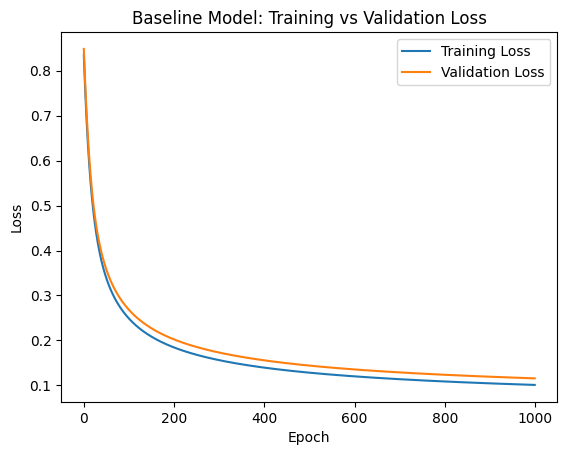

In [ ]:
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline Model: Training vs Validation Loss")
plt.legend()
plt.show()


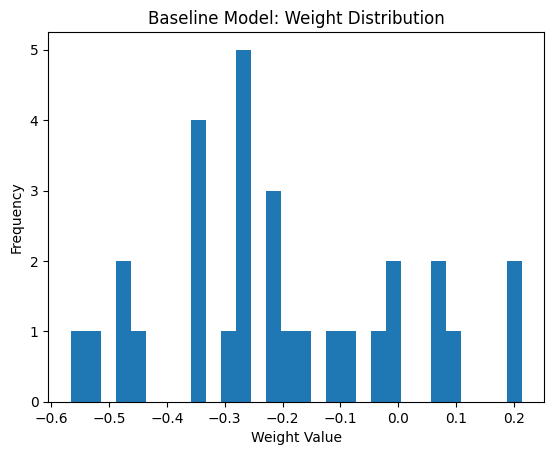

,Feature,Weight,Abs_Weight
20,worst radius,-0.566170,0.566170
22,worst perimeter,-0.531439,0.531439
27,worst concave points,-0.485599,0.485599
2,mean perimeter,-0.479005,0.479005
21,worst texture,-0.453668,0.453668
13,area error,-0.355656,0.355656
6,mean concavity,-0.352607,0.352607
24,worst smoothness,-0.339930,0.339930
23,worst area,-0.333074,0.333074
0,mean radius,-0.306256,0.306256


In [ ]:
plt.figure()
plt.hist(weights, bins=30)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Baseline Model: Weight Distribution")
plt.show()

weights_df = pd.DataFrame({
    "Feature": data.feature_names,
    "Weight": weights
})

weights_df["Abs_Weight"] = np.abs(weights_df["Weight"])
weights_df = weights_df.sort_values(by="Abs_Weight", ascending=False)

weights_df


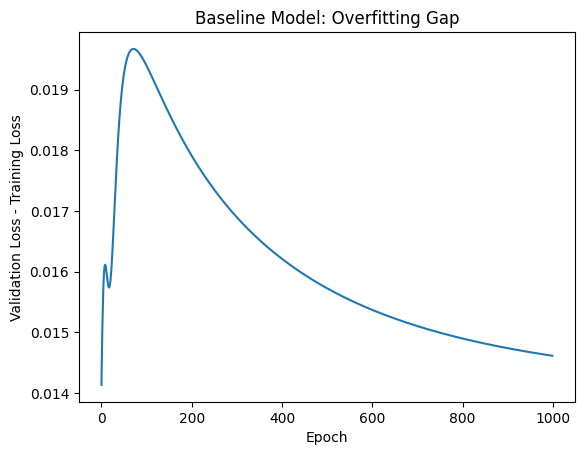

In [ ]:
loss_gap = np.array(val_losses) - np.array(train_losses)

plt.figure()
plt.plot(loss_gap)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss - Training Loss")
plt.title("Baseline Model: Overfitting Gap")
plt.show()


The gap is small and decreasing, showing the model is not overfitting and generalization improves with training.
The early peak reflects initial adaptation, after which training and validation losses converge stably.

# Logistic Regression with L1 Regularization

L1 regularization adds the sum of absolute values of the weights to the loss function as a penalty.
It encourages sparse models by driving less important weights exactly to zero.

In [ ]:
lambda_l1 = 0.01
model_l1 = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model_l1.parameters(), lr=0.01)


In [ ]:
epochs = 1000
train_losses_l1 = []
val_losses_l1 = []
costs_l1 = []
zero_weights_count = []

for epoch in range(epochs):
    model_l1.train()
    optimizer.zero_grad()

    outputs = model_l1(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    l1_penalty = 0
    for param in model_l1.parameters():
        l1_penalty += torch.sum(torch.abs(param))

    cost = loss + lambda_l1 * l1_penalty

    cost.backward()
    optimizer.step()

    train_losses_l1.append(loss.item())
    costs_l1.append(cost.item())

    weights_l1 = model_l1.linear.weight.detach().numpy().flatten()
    zero_weights_count.append(np.sum(np.isclose(weights_l1, 0.0)))

    model_l1.eval()
    with torch.no_grad():
        val_outputs = model_l1(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses_l1.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {loss.item():.4f}, "
              f"Val Loss: {val_loss.item():.4f}, "
              f"Cost: {cost.item():.4f}")


Epoch [10/1000], Train Loss: 0.7140, Val Loss: 0.6943, Cost: 0.7394
Epoch [20/1000], Train Loss: 0.5559, Val Loss: 0.5477, Cost: 0.5811
Epoch [30/1000], Train Loss: 0.4651, Val Loss: 0.4639, Cost: 0.4908
Epoch [40/1000], Train Loss: 0.4065, Val Loss: 0.4096, Cost: 0.4325
Epoch [50/1000], Train Loss: 0.3655, Val Loss: 0.3714, Cost: 0.3920
Epoch [60/1000], Train Loss: 0.3353, Val Loss: 0.3432, Cost: 0.3627
Epoch [70/1000], Train Loss: 0.3119, Val Loss: 0.3214, Cost: 0.3403
Epoch [80/1000], Train Loss: 0.2932, Val Loss: 0.3040, Cost: 0.3226
Epoch [90/1000], Train Loss: 0.2778, Val Loss: 0.2895, Cost: 0.3081
Epoch [100/1000], Train Loss: 0.2648, Val Loss: 0.2774, Cost: 0.2962
Epoch [110/1000], Train Loss: 0.2538, Val Loss: 0.2670, Cost: 0.2862
Epoch [120/1000], Train Loss: 0.2442, Val Loss: 0.2580, Cost: 0.2776
Epoch [130/1000], Train Loss: 0.2359, Val Loss: 0.2502, Cost: 0.2702
Epoch [140/1000], Train Loss: 0.2286, Val Loss: 0.2433, Cost: 0.2639
Epoch [150/1000], Train Loss: 0.2220, Val L

In [ ]:
model_l1.eval()
with torch.no_grad():
    train_preds = (model_l1(X_train_tensor) >= 0.5).float()
    train_acc_l1 = (train_preds == y_train_tensor).float().mean()

    val_preds = (model_l1(X_val_tensor) >= 0.5).float()
    val_acc_l1 = (val_preds == y_val_tensor).float().mean()

print("L1 Training Accuracy:", train_acc_l1.item())
print("L1 Validation Accuracy:", val_acc_l1.item())


L1 Training Accuracy: 0.9741784334182739
L1 Validation Accuracy: 0.9650349617004395


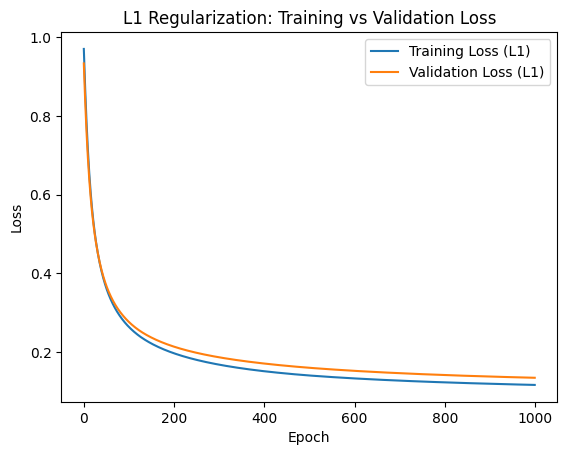

In [ ]:
plt.figure()
plt.plot(train_losses_l1, label="Training Loss (L1)")
plt.plot(val_losses_l1, label="Validation Loss (L1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("L1 Regularization: Training vs Validation Loss")
plt.legend()
plt.show()


The training–validation gap is smaller than the baseline, showing reduced variance due to L1 regularization.
The trade-off is higher bias, which explains the slightly worse accuracy compared to the unregularized model.

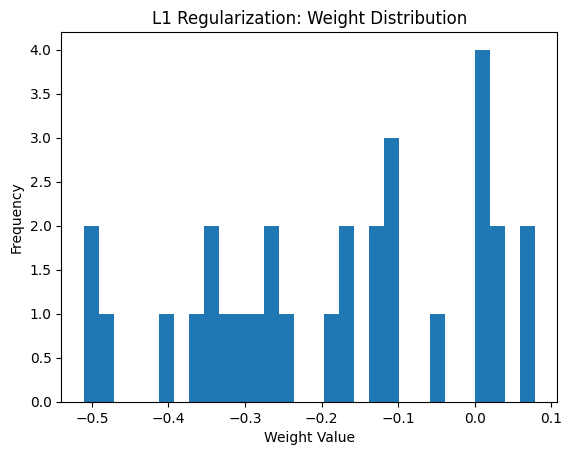

In [ ]:
plt.figure()
plt.hist(weights_l1, bins=30)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("L1 Regularization: Weight Distribution")
plt.show()


# Logistic Regression with L2 Regularization

L2 regularization adds the sum of squared weights to the loss function as a penalty.
It discourages large weights by shrinking them smoothly, improving stability and generalization.

In [ ]:
lambda_l2 = 0.01
model_l2 = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()

optimizer = torch.optim.SGD(
    model_l2.parameters(),
    lr=0.01,
    weight_decay=lambda_l2
)


In [ ]:
epochs = 1000
train_losses_l2 = []
val_losses_l2 = []

for epoch in range(epochs):
    model_l2.train()
    optimizer.zero_grad()

    outputs = model_l2(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    train_losses_l2.append(train_loss.item())

    model_l2.eval()
    with torch.no_grad():
        val_outputs = model_l2(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses_l2.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss.item():.4f}, "
              f"Val Loss: {val_loss.item():.4f}")


Epoch [10/1000], Train Loss: 0.5594, Val Loss: 0.5227
Epoch [20/1000], Train Loss: 0.4661, Val Loss: 0.4415
Epoch [30/1000], Train Loss: 0.4058, Val Loss: 0.3881
Epoch [40/1000], Train Loss: 0.3635, Val Loss: 0.3504
Epoch [50/1000], Train Loss: 0.3321, Val Loss: 0.3222
Epoch [60/1000], Train Loss: 0.3077, Val Loss: 0.3003
Epoch [70/1000], Train Loss: 0.2882, Val Loss: 0.2827
Epoch [80/1000], Train Loss: 0.2721, Val Loss: 0.2683
Epoch [90/1000], Train Loss: 0.2587, Val Loss: 0.2562
Epoch [100/1000], Train Loss: 0.2472, Val Loss: 0.2458
Epoch [110/1000], Train Loss: 0.2372, Val Loss: 0.2369
Epoch [120/1000], Train Loss: 0.2285, Val Loss: 0.2291
Epoch [130/1000], Train Loss: 0.2208, Val Loss: 0.2222
Epoch [140/1000], Train Loss: 0.2139, Val Loss: 0.2160
Epoch [150/1000], Train Loss: 0.2077, Val Loss: 0.2105
Epoch [160/1000], Train Loss: 0.2022, Val Loss: 0.2055
Epoch [170/1000], Train Loss: 0.1971, Val Loss: 0.2010
Epoch [180/1000], Train Loss: 0.1924, Val Loss: 0.1968
Epoch [190/1000], T

In [ ]:
model_l2.eval()
with torch.no_grad():
    train_preds = (model_l2(X_train_tensor) >= 0.5).float()
    train_acc_l2 = (train_preds == y_train_tensor).float().mean()

    val_preds = (model_l2(X_val_tensor) >= 0.5).float()
    val_acc_l2 = (val_preds == y_val_tensor).float().mean()

print("L2 Training Accuracy:", train_acc_l2.item())
print("L2 Validation Accuracy:", val_acc_l2.item())


L2 Training Accuracy: 0.9812206625938416
L2 Validation Accuracy: 0.9720279574394226


In [ ]:
weights_l2 = model_l2.linear.weight.detach().numpy().flatten()

avg_weight_mag_l2 = np.mean(np.abs(weights_l2))
max_weight_mag_l2 = np.max(np.abs(weights_l2))

print("Average |weight| (L2):", avg_weight_mag_l2)
print("Max |weight| (L2):", max_weight_mag_l2)


Average |weight| (L2): 0.24947271
Max |weight| (L2): 0.46831143


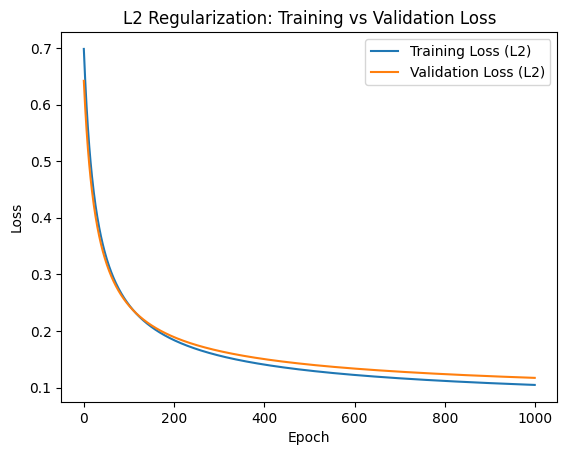

In [ ]:
plt.figure()
plt.plot(train_losses_l2, label="Training Loss (L2)")
plt.plot(val_losses_l2, label="Validation Loss (L2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("L2 Regularization: Training vs Validation Loss")
plt.legend()
plt.show()


The training and validation loss curves are very close, showing strong generalization and reduced variance compared to the baseline.
Accuracy remains high with minimal drop, indicating L2 stabilizes learning by shrinking weights without sacrificing performance.

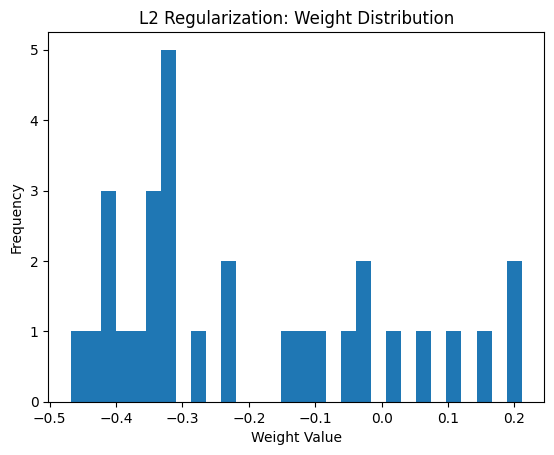

In [ ]:
plt.figure()
plt.hist(weights_l2, bins=30)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("L2 Regularization: Weight Distribution")
plt.show()


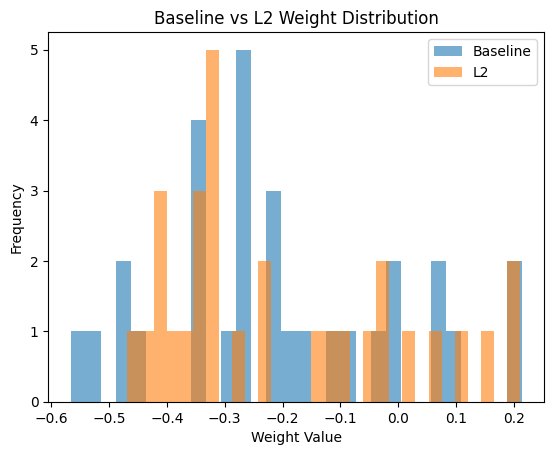

In [ ]:
plt.figure()
plt.hist(weights, bins=30, alpha=0.6, label="Baseline")
plt.hist(weights_l2, bins=30, alpha=0.6, label="L2")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Baseline vs L2 Weight Distribution")
plt.legend()
plt.show()


# Logistic Regression with Elastic Net Regularization

In [ ]:
lambda_en = 0.01      # overall regularization strength
alpha = 0.5           # mixing ratio (0 = pure L2, 1 = pure L1)

lambda_l1 = lambda_en * alpha
lambda_l2 = lambda_en * (1 - alpha)


In [ ]:
model_en = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()

# L2 handled via weight_decay
optimizer = torch.optim.SGD(
    model_en.parameters(),
    lr=0.01,
    weight_decay=lambda_l2
)


In [ ]:
epochs = 100
train_losses_en = []
val_losses_en = []
costs_en = []
zero_weights_en = []

for epoch in range(epochs):
    # ---- Training ----
    model_en.train()
    optimizer.zero_grad()

    outputs = model_en(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # L1 penalty (manual)
    l1_penalty = 0
    for param in model_en.parameters():
        l1_penalty += torch.sum(torch.abs(param))

    cost = loss + lambda_l1 * l1_penalty
    cost.backward()
    optimizer.step()

    train_losses_en.append(loss.item())
    costs_en.append(cost.item())

    # Count zero weights
    weights_en = model_en.linear.weight.detach().numpy().flatten()
    zero_weights_en.append(np.sum(np.isclose(weights_en, 0.0)))

    # ---- Validation ----
    model_en.eval()
    with torch.no_grad():
        val_outputs = model_en(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses_en.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {loss.item():.4f}, "
              f"Val Loss: {val_loss.item():.4f}, "
              f"Cost: {cost.item():.4f}")


Epoch [10/100], Train Loss: 0.3993, Val Loss: 0.3963, Cost: 0.4148
Epoch [20/100], Train Loss: 0.3622, Val Loss: 0.3625, Cost: 0.3783
Epoch [30/100], Train Loss: 0.3335, Val Loss: 0.3361, Cost: 0.3502
Epoch [40/100], Train Loss: 0.3105, Val Loss: 0.3149, Cost: 0.3278
Epoch [50/100], Train Loss: 0.2917, Val Loss: 0.2975, Cost: 0.3095
Epoch [60/100], Train Loss: 0.2760, Val Loss: 0.2828, Cost: 0.2941
Epoch [70/100], Train Loss: 0.2625, Val Loss: 0.2703, Cost: 0.2811
Epoch [80/100], Train Loss: 0.2509, Val Loss: 0.2595, Cost: 0.2699
Epoch [90/100], Train Loss: 0.2408, Val Loss: 0.2501, Cost: 0.2602
Epoch [100/100], Train Loss: 0.2320, Val Loss: 0.2418, Cost: 0.2517


In [ ]:
model_en.eval()
with torch.no_grad():
    train_preds = (model_en(X_train_tensor) >= 0.5).float()
    train_acc_en = (train_preds == y_train_tensor).float().mean()

    val_preds = (model_en(X_val_tensor) >= 0.5).float()
    val_acc_en = (val_preds == y_val_tensor).float().mean()

print("Elastic Net Training Accuracy:", train_acc_en.item())
print("Elastic Net Validation Accuracy:", val_acc_en.item())


Elastic Net Training Accuracy: 0.9530516266822815
Elastic Net Validation Accuracy: 0.9510489702224731


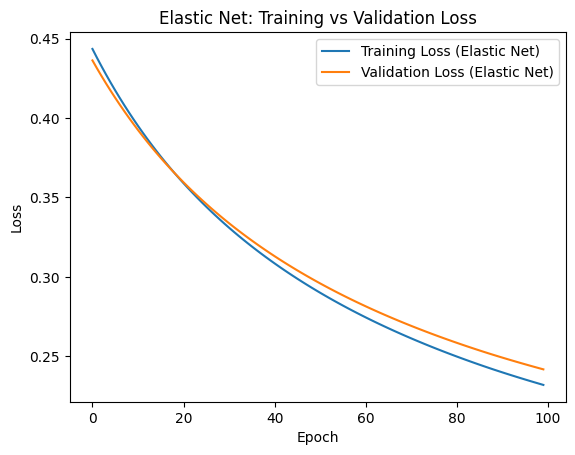

In [ ]:
plt.figure()
plt.plot(train_losses_en, label="Training Loss (Elastic Net)")
plt.plot(val_losses_en, label="Validation Loss (Elastic Net)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Elastic Net: Training vs Validation Loss")
plt.legend()
plt.show()


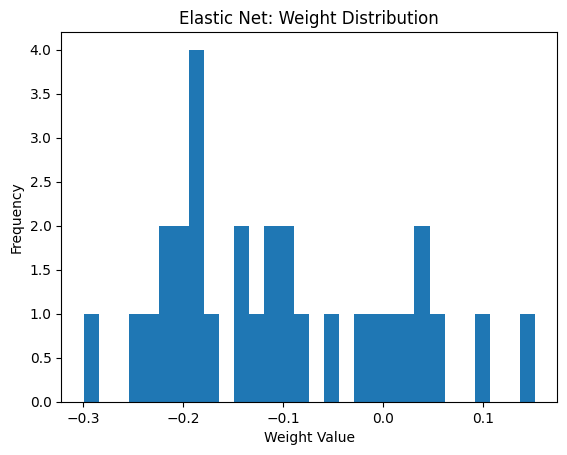

In [ ]:
plt.figure()
plt.hist(weights_en, bins=30)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Elastic Net: Weight Distribution")
plt.show()


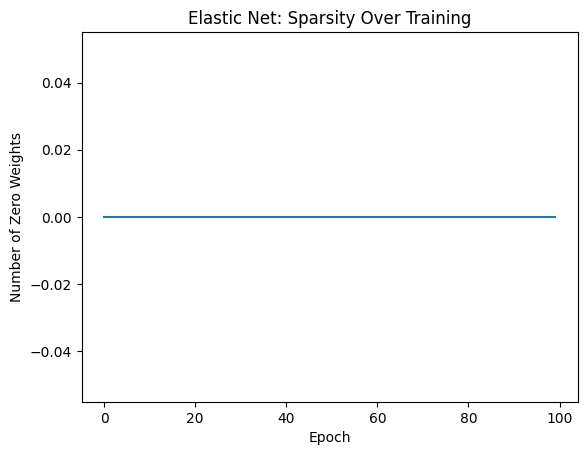

In [ ]:
plt.figure()
plt.plot(zero_weights_en)
plt.xlabel("Epoch")
plt.ylabel("Number of Zero Weights")
plt.title("Elastic Net: Sparsity Over Training")
plt.show()


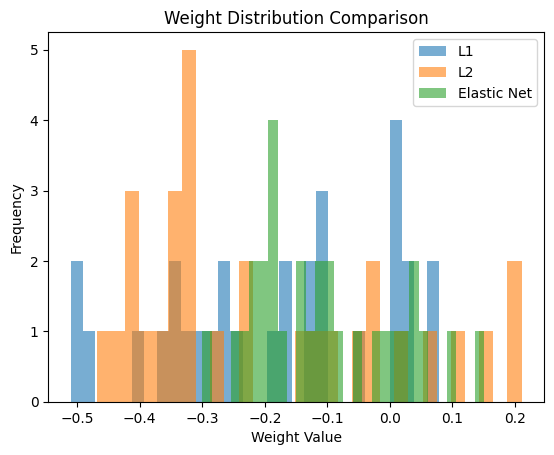

In [ ]:
plt.figure()
plt.hist(weights_l1, bins=30, alpha=0.6, label="L1")
plt.hist(weights_l2, bins=30, alpha=0.6, label="L2")
plt.hist(weights_en, bins=30, alpha=0.6, label="Elastic Net")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Weight Distribution Comparison")
plt.legend()
plt.show()


# Comparison

In [ ]:
results = {
    "Model": ["Baseline", "L1", "L2", "Elastic Net"],
    "Train Loss": [
        train_losses[-1],
        train_losses_l1[-1],
        train_losses_l2[-1],
        train_losses_en[-1]
    ],
    "Validation Loss": [
        val_losses[-1],
        val_losses_l1[-1],
        val_losses_l2[-1],
        val_losses_en[-1]
    ],
    "Train Accuracy": [
        train_acc.item(),
        train_acc_l1.item(),
        train_acc_l2.item(),
        train_acc_en.item()
    ],
    "Validation Accuracy": [
        val_acc.item(),
        val_acc_l1.item(),
        val_acc_l2.item(),
        val_acc_en.item()
    ],
    "Zero Weights": [
        np.sum(np.isclose(weights, 0.0)),
        np.sum(np.isclose(weights_l1, 0.0)),
        np.sum(np.isclose(weights_l2, 0.0)),
        np.sum(np.isclose(weights_en, 0.0))
    ],
    "Avg |Weight|": [
        np.mean(np.abs(weights)),
        np.mean(np.abs(weights_l1)),
        np.mean(np.abs(weights_l2)),
        np.mean(np.abs(weights_en))
    ]
}

df_results = pd.DataFrame(results)
df_results


,Model,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy,Zero Weights,Avg |Weight|
0,Baseline,0.100960,0.115575,0.981221,0.979021,0,0.248163
1,L1,0.116310,0.134488,0.974178,0.965035,0,0.202298
2,L2,0.104817,0.117266,0.981221,0.972028,0,0.249473
3,Elastic Net,0.232009,0.241810,0.953052,0.951049,0,0.131151


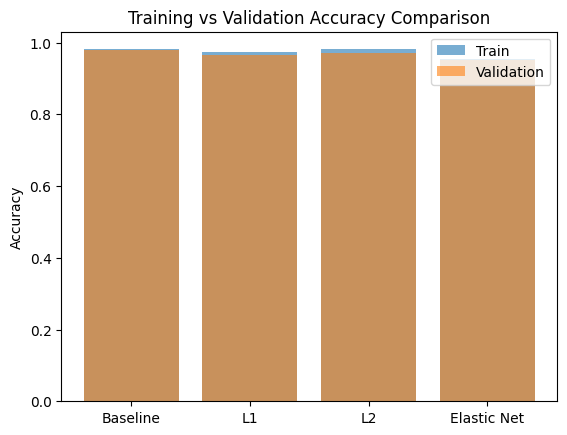

In [ ]:
plt.figure()
plt.bar(df_results["Model"], df_results["Train Accuracy"], alpha=0.6, label="Train")
plt.bar(df_results["Model"], df_results["Validation Accuracy"], alpha=0.6, label="Validation")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy Comparison")
plt.legend()
plt.show()


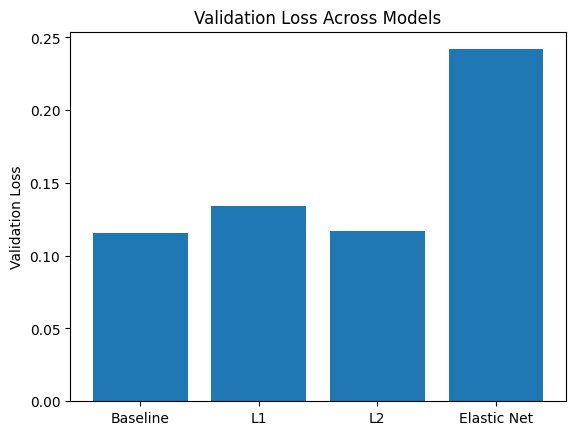

In [ ]:
plt.figure()
plt.bar(df_results["Model"], df_results["Validation Loss"])
plt.ylabel("Validation Loss")
plt.title("Validation Loss Across Models")
plt.show()


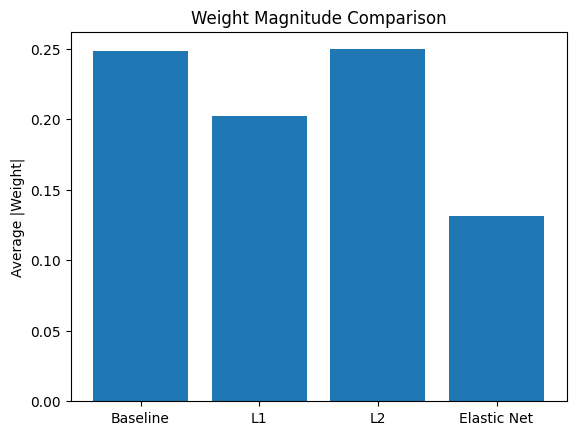

In [ ]:
plt.figure()
plt.bar(df_results["Model"], df_results["Avg |Weight|"])
plt.ylabel("Average |Weight|")
plt.title("Weight Magnitude Comparison")
plt.show()


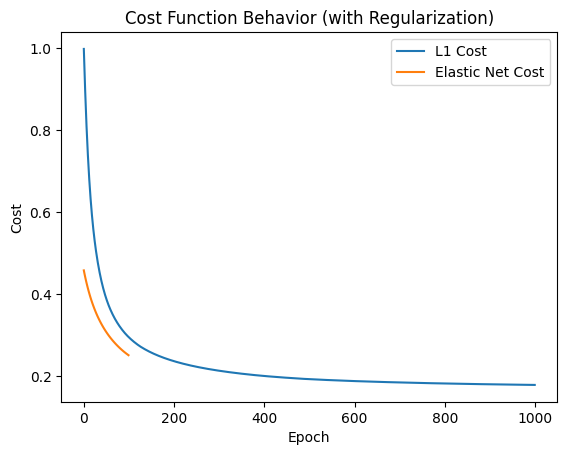

In [ ]:
plt.figure()
plt.plot(costs_l1, label="L1 Cost")
plt.plot(costs_en, label="Elastic Net Cost")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Cost Function Behavior (with Regularization)")
plt.legend()
plt.show()


# Overfitting and Generalization Analysis

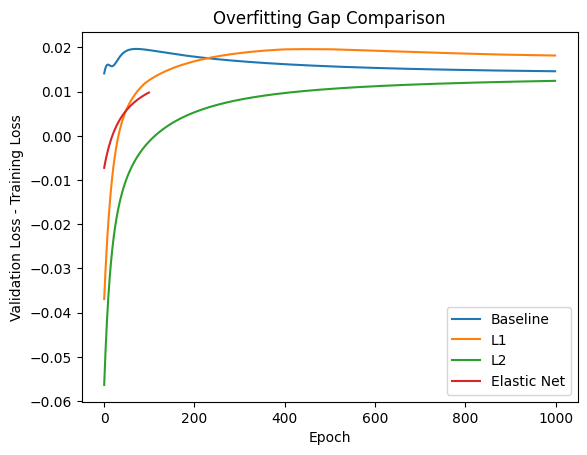

In [ ]:
gap_baseline = np.array(val_losses) - np.array(train_losses)
gap_l1 = np.array(val_losses_l1) - np.array(train_losses_l1)
gap_l2 = np.array(val_losses_l2) - np.array(train_losses_l2)
gap_en = np.array(val_losses_en) - np.array(train_losses_en)

plt.figure()
plt.plot(gap_baseline, label="Baseline")
plt.plot(gap_l1, label="L1")
plt.plot(gap_l2, label="L2")
plt.plot(gap_en, label="Elastic Net")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss - Training Loss")
plt.title("Overfitting Gap Comparison")
plt.legend()
plt.show()


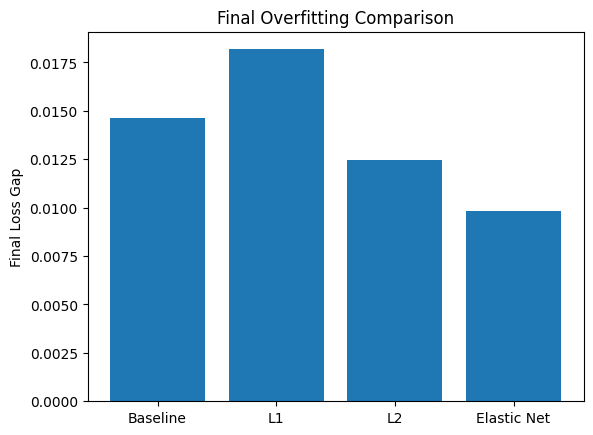

In [ ]:
final_gaps = [
    gap_baseline[-1],
    gap_l1[-1],
    gap_l2[-1],
    gap_en[-1]
]

models = ["Baseline", "L1", "L2", "Elastic Net"]

plt.figure()
plt.bar(models, final_gaps)
plt.ylabel("Final Loss Gap")
plt.title("Final Overfitting Comparison")
plt.show()


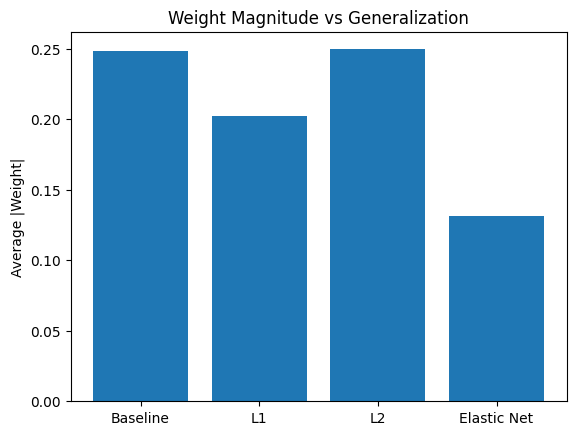

In [ ]:
plt.figure()
plt.bar(
    ["Baseline", "L1", "L2", "Elastic Net"],
    [
        np.mean(np.abs(weights)),
        np.mean(np.abs(weights_l1)),
        np.mean(np.abs(weights_l2)),
        np.mean(np.abs(weights_en))
    ]
)
plt.ylabel("Average |Weight|")
plt.title("Weight Magnitude vs Generalization")
plt.show()


# Effect of Regularization Strength (λ) on Model Training

In [ ]:
lambdas = [0.0001, 0.001, 0.01, 0.1, 1.0]
epochs = 1000

In [ ]:
def train_l1(lambda_l1):
    model = LogisticRegressionModel(input_dim)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()

    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters())
        cost = loss + lambda_l1 * l1_penalty

        cost.backward()
        optimizer.step()

    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor).item()
        val_loss = criterion(model(X_val_tensor), y_val_tensor).item()
        val_acc = ((model(X_val_tensor) >= 0.5).float() == y_val_tensor).float().mean().item()

    weights = model.linear.weight.detach().numpy().flatten()
    zero_weights = np.sum(np.isclose(weights, 0.0))
    avg_weight = np.mean(np.abs(weights))

    return train_loss, val_loss, val_acc, zero_weights, avg_weight


In [ ]:
def train_l2(lambda_l2):
    model = LogisticRegressionModel(input_dim)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.01, weight_decay=lambda_l2
    )
    criterion = nn.BCELoss()

    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor).item()
        val_loss = criterion(model(X_val_tensor), y_val_tensor).item()
        val_acc = ((model(X_val_tensor) >= 0.5).float() == y_val_tensor).float().mean().item()

    weights = model.linear.weight.detach().numpy().flatten()
    avg_weight = np.mean(np.abs(weights))

    return train_loss, val_loss, val_acc, avg_weight


In [ ]:
def train_elastic_net(lambda_en, alpha=0.5):
    lambda_l1 = lambda_en * alpha
    lambda_l2 = lambda_en * (1 - alpha)

    model = LogisticRegressionModel(input_dim)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.01, weight_decay=lambda_l2
    )
    criterion = nn.BCELoss()

    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters())
        cost = loss + lambda_l1 * l1_penalty

        cost.backward()
        optimizer.step()

    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor).item()
        val_loss = criterion(model(X_val_tensor), y_val_tensor).item()
        val_acc = ((model(X_val_tensor) >= 0.5).float() == y_val_tensor).float().mean().item()

    weights = model.linear.weight.detach().numpy().flatten()
    zero_weights = np.sum(np.isclose(weights, 0.0))
    avg_weight = np.mean(np.abs(weights))

    return train_loss, val_loss, val_acc, zero_weights, avg_weight


In [ ]:
l1_results = []
l2_results = []
en_results = []

for lam in lambdas:
    l1_results.append(train_l1(lam))
    l2_results.append(train_l2(lam))
    en_results.append(train_elastic_net(lam))


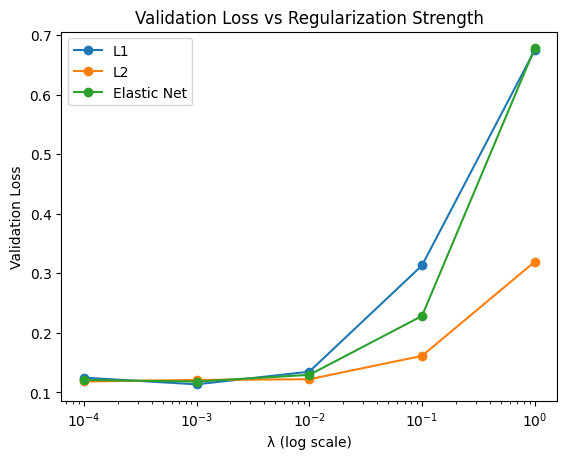

In [ ]:
plt.figure()
plt.plot(lambdas, [r[1] for r in l1_results], marker='o', label="L1")
plt.plot(lambdas, [r[1] for r in l2_results], marker='o', label="L2")
plt.plot(lambdas, [r[1] for r in en_results], marker='o', label="Elastic Net")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Regularization Strength")
plt.legend()
plt.show()


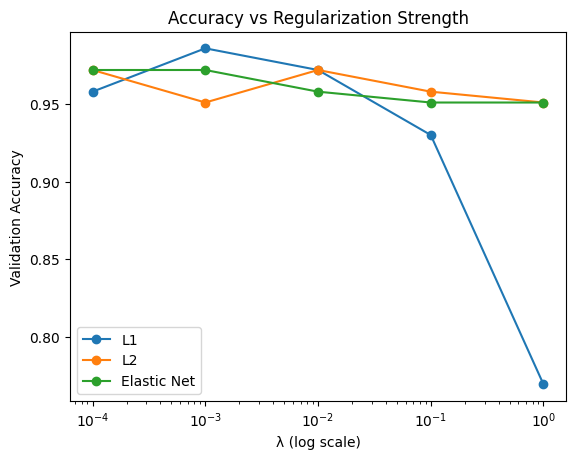

In [ ]:
plt.figure()
plt.plot(lambdas, [r[2] for r in l1_results], marker='o', label="L1")
plt.plot(lambdas, [r[2] for r in l2_results], marker='o', label="L2")
plt.plot(lambdas, [r[2] for r in en_results], marker='o', label="Elastic Net")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Regularization Strength")
plt.legend()
plt.show()


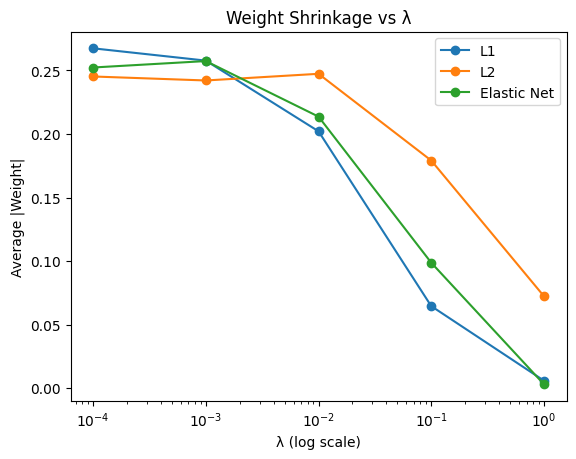

In [ ]:
plt.figure()
plt.plot(lambdas, [r[4] for r in l1_results], marker='o', label="L1")
plt.plot(lambdas, [r[3] for r in l2_results], marker='o', label="L2")
plt.plot(lambdas, [r[4] for r in en_results], marker='o', label="Elastic Net")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Average |Weight|")
plt.title("Weight Shrinkage vs λ")
plt.legend()
plt.show()


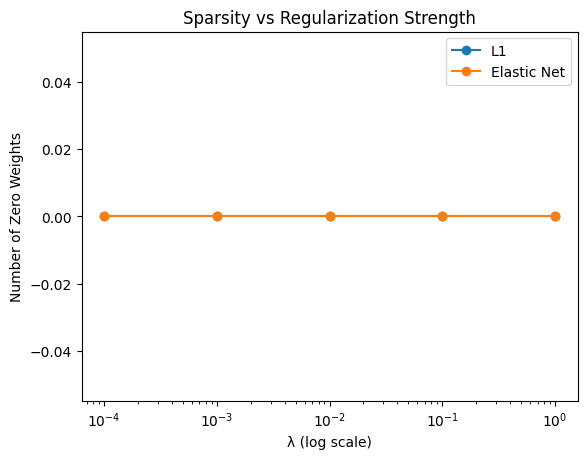

In [ ]:
plt.figure()
plt.plot(lambdas, [r[3] for r in l1_results], marker='o', label="L1")
plt.plot(lambdas, [r[3] for r in en_results], marker='o', label="Elastic Net")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Number of Zero Weights")
plt.title("Sparsity vs Regularization Strength")
plt.legend()
plt.show()
